In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import copy
import sys
sys.path.append('../py_modules')
import module_shiftedcmap as scmap
import module_clusterheatmap_de as clustermap
import module_denrichr as denrichr
import module_plt_params_de
import module_venn_de as venn
import module_kde_de as kde
from sklearn import preprocessing

plt.rcParams.update({'figure.max_open_warning': 0})

df = pd.read_table("mitoproteomics_chronic_preprocessed.txt")

,EAE1,EAE2,C1,C2,C3,C4,C5,EAE3,EAE4
EAE1,1.000000,0.983318,0.962374,0.959641,0.967854,0.964608,0.962773,0.965721,0.975386
EAE2,0.983318,1.000000,0.967468,0.960895,0.970874,0.971679,0.974196,0.952544,0.968444
C1,0.962374,0.967468,1.000000,0.991261,0.987342,0.984259,0.985590,0.975409,0.980453
C2,0.959641,0.960895,0.991261,1.000000,0.985986,0.980228,0.980927,0.978928,0.978461
C3,0.967854,0.970874,0.987342,0.985986,1.000000,0.991172,0.990262,0.972632,0.972366
C4,0.964608,0.971679,0.984259,0.980228,0.991172,1.000000,0.989830,0.965106,0.968766
C5,0.962773,0.974196,0.985590,0.980927,0.990262,0.989830,1.000000,0.963827,0.966835
EAE3,0.965721,0.952544,0.975409,0.978928,0.972632,0.965106,0.963827,1.000000,0.984801
EAE4,0.975386,0.968444,0.980453,0.978461,0.972366,0.968766,0.966835,0.984801,1.000000


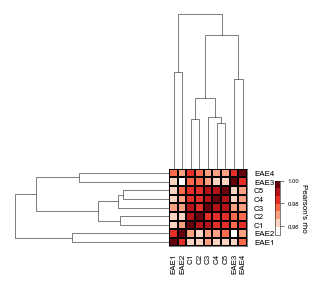

In [2]:
# correlation matrix
import imp
imp.reload(clustermap)
cor_matrix = df.loc[:, df.columns.str.contains('ctrl|eae') & ~df.columns.str.contains('mean')].corr()
samplenames = ['C1', 'C2', 'C3', 'C4', 'C5', 'EAE1', 'EAE2', 'EAE3', 'EAE4']
cor_matrix.columns = samplenames
cor_matrix.index = samplenames
clustermap.clustermap(cor_matrix, linewidth=.25, cbar_label="Pearson's rho", fancycmap=True, coldend=True)
#plt.savefig("output/mitoproteomics_correlation_chronic.pdf", transparent=True, dpi = 900, bbox_inches="tight")

(-0.05500000000000001, 0.05500000000000001, 0.0, 1.0)

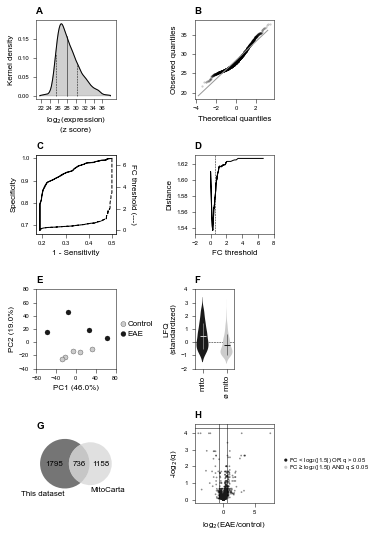

In [3]:
fig = plt.figure(figsize=(1.1,1.1))

# QQ

imp.reload(kde)
kde.kde_function(df.iloc[:,1], ax=[fig.add_axes([0,1.7,1,1]),fig.add_axes([2,1.7,1,1])], titles=['A', 'B'])

# roc analysis

def sensitivity(x):
    return(len(df.loc[df.p <= 0.05, :]) / (len(df.loc[df.p <= 0.05, :]) + len(df.loc[(df.p <= 0.05) & (df.log2fc < x), :])))

def specificity(x):
    return(len(df.loc[df.p > 0.05, :]) / (len(df.loc[df.p > 0.05, :]) + len(df.loc[(df.p > 0.05) & (df.log2fc > x), :])))

sens = []
spec = []
tsens = []
tspec = []
dist = []
xvals= np.abs(np.log2(np.linspace(0.01,4,250)))
for x in xvals:
    sens.append(sensitivity(x))
    tsens.append(1-sensitivity(x))
    spec.append(specificity(x))
    tspec.append(1-specificity(x))
    dist.append(np.sqrt(np.sum([np.exp(1-sensitivity(x)), np.exp(1-specificity(x))])))

ax = fig.add_axes([0,0,1,1])
ax.plot(tsens, spec, c='black', lw=1)
ax.set_xlabel('1 - Sensitivity')
ax.set_ylabel('Specificity', color='black')
ax = ax.twinx()
ax.plot(tsens, xvals, c='k', ls='dashed', lw=1)
ax.set_ylabel('FC threshold (---)', rotation=270, labelpad=10)
ax.set_title('C', weight=600, loc='left')

ax = fig.add_axes([2,0,1,1])
ax.plot(xvals, dist, c='k', lw=1)
ax.set_xlabel('FC threshold')
ax.set_ylabel('Distance')
ax.set_xticks(np.round(ax.get_xticks(), 2))
ax.axvline(np.log2(1.5), c = "black", linestyle = "dashed", linewidth = 0.5)
ax.set_title('D', weight=600, loc='left')

# pca

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = df.loc[:, df.columns.str.contains('ctrl|eae') & ~df.columns.str.contains('mean')]
x = StandardScaler().fit_transform(np.transpose(x)) # Standardizing the features

pca = PCA(n_components = 2)
pcs = pca.fit_transform(x)
pc1var = round(pca.explained_variance_ratio_[0],2) * 100
pc2var = round(pca.explained_variance_ratio_[1],2) * 100
pcadf = pd.DataFrame(data = pcs, columns = ["pc1", "pc2"])
pcadf["sample"] = df.loc[:, df.columns.str.contains('ctrl|eae') & ~df.columns.str.contains('mean')].columns

ax = fig.add_axes([0,-1.7,1,1])

for sample, color in zip(["lfqctrl", "lfqeae"], ['0.8', '0.1']):
    ax.scatter('pc1', 'pc2', data=pcadf.loc[pcadf['sample'].str.contains(sample), :], s=25, edgecolors='k', lw=.25, label=sample, c=color)
ax.set_xlabel("PC1 ("+str(pc1var)+"%)")
ax.set_ylabel("PC2 ("+str(pc2var)+"%)")
ax.set_title('E', weight=600, loc='left')
ax.set_xticks(np.arange(-80,90)[::40])
ax.set_xlim([-80,80])
ax.set_ylim([-40,80])

ax = fig.add_axes([1.1,-1.7,1,1])
ax.scatter([0,0], [-1,1], c=['0.1', '0.8'], s=25, lw=.25, edgecolors='k', clip_on=False)
ax.text(0.1, 1, 'Control', va='center')
ax.text(0.1, -1, 'EAE', va='center')
ax.set_ylim([-8,8])
ax.set_xlim([0,2])
ax.axis('off')

# mito versus non mito abundance

scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(np.array(df.iloc[:, 1:12]))
df_std = copy.copy(df)
df_std.iloc[: ,1:12] = scaled_df

mito = df_std.loc[df_std.mitocarta==1, :].iloc[: ,1:12].mean(axis=1)
nonmito = df_std.loc[df_std.mitocarta==0, :].iloc[: ,1:12].mean(axis=1)

ax = fig.add_axes([2,-1.7,.5,1])
plot = ax.violinplot([mito, nonmito], showmeans=True)
ax.set_ylabel('LFQ\n(standardized)')
ax.set_xticks([1,2])
ax.set_xticklabels(['mito', '\u00f8 mito'], rotation=90, ha= 'center', va='top', fontsize=8)
for pc, color in zip(plot['bodies'], ['0.1', '0.8']):
    pc.set_facecolor(color)
    pc.set_edgecolor('None')
    pc.set_alpha(1)
    pc.set_linewidths(.5)
plot['cbars'].set_linewidth(0)
plot['cmaxes'].set_linewidth(0)
plot['cmins'].set_linewidth(0)
plot['cmeans'].set_linewidth(0)

ax.scatter(1, np.mean(mito), color='0.8', linewidth=1, zorder=3, marker="_")
ax.vlines(1, np.sqrt(np.var(mito))+np.mean(mito), -np.sqrt(np.var(mito))+np.mean(mito), color='0.8', linestyle='-', lw=.5)
ax.scatter(2, np.mean(nonmito), color='0.1', linewidth=1, zorder=3, marker="_")
ax.vlines(2, np.sqrt(np.var(nonmito))+np.mean(nonmito), -np.sqrt(np.var(nonmito))+np.mean(nonmito), color='0.1', linestyle='-', lw=.5)
ax.axhline(0, color='k', linestyle='--', zorder=-1)
ax.set_title('F', weight=600, loc='left')

ax.set_yticks(np.arange(-2,5))
ax.set_ylim([-2,4])

# venn diagram
ax = fig.add_axes([0,-3.4,1,1])
len_mitocarta, len_dfmito, len_dfnomito = len(pd.read_csv('repos/Mouse.MitoCarta2.0.csv', sep=';')), len(df.loc[df.mitocarta==1,:]), len(df.loc[df.mitocarta==0,:])
venn.venn2(subsets = (len_dfnomito, len_mitocarta, len_dfmito), set_labels = ('This dataset', 'MitoCarta'), set_colors=('0.1', '0.8'), normalize_to=2, alpha = 0.6, ax=ax)
ax.set_title('G', weight=600, loc='left')


# volcano

ax = fig.add_axes([2,-3.4,1,1])

c = ['0.5' if enriched == 1 else '0.1' for enriched in df.enriched]
c = ['0.5' if q <= .05 else '0.1' for q in df.q]
ax.scatter(df.log2fc, -np.log2(df.q), s=3, alpha=.5, c=c, lw=0)
ax.axhline(-np.log2(.05))
ax.axvline(-np.log2(1.5)), ax.axvline(np.log2(1.5))
ax.set_xlabel('log$_{2}$(EAE/control)')
ax.set_ylabel('-log$_{2}$(q)')
ax.set_title('H', weight=600, loc='left')

legend_dict = dict(zip(['FC < log$_{2}$(|1.5|) OR q > 0.05', 'FC \u2265 log$_{2}$(|1.5|) AND q \u2264 0.05'], ['0.1', '0.8']))
y = np.linspace(0,1,12)[[6, 5]]
x = [0]*2
ax = fig.add_axes([3.1,-3.4,.1,1])
ax.scatter(x, y, s=10, c=legend_dict.values(), lw=0)
for i, text in enumerate(legend_dict.keys()):
    ax.text(x[i]+.05,y[i], text, va='center', ha='left', fontsize=6)
ax.set_ylim([0,1])
ax.axis('off')

#plt.savefig("output/supplement01.pdf", facecolor='white', transparent=True, dpi = 900, bbox_inches="tight")

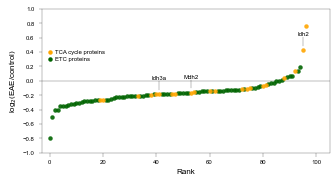

In [5]:
import nezzworker.nezzworker as nezzworker
kegg = nezzworker.getgenesets('kegg').run()

tca_genes = [x.capitalize() for x in kegg['KEGG_CITRATE_CYCLE_TCA_CYCLE']]
tca_genes = [x.capitalize() for x in nezzworker.getgenesets('reactome7.1').run()['REACTOME_CITRIC_ACID_CYCLE_TCA_CYCLE'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()]
tca_genes = [x.capitalize() for x in nezzworker.getgenesets('custom_all').run()['Citric acid cycle (TCA cycle)'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()]
ret_genes = [x.capitalize() for x in kegg['KEGG_OXIDATIVE_PHOSPHORYLATION']]
ret_genes = [x.capitalize() for x in nezzworker.getgenesets('reactome7.1').run()['REACTOME_RESPIRATORY_ELECTRON_TRANSPORT'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()]
ret_genes = [x.capitalize() for x in nezzworker.getgenesets('custom_all').run()['Respiratory electron transport'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()]

tca_ret = df.sort_values(by='log2fc').loc[df.gene.isin(tca_genes+ret_genes)]
tca_ret['rank'] = range(len(tca_ret))

fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])

ax.axhline(0, lw=.25, zorder=-1)
ax.scatter('rank','log2fc', data=tca_ret.loc[tca_ret.gene.isin(ret_genes)], s=20, lw=0, alpha=.9, color='darkgreen')
ax.scatter('rank','log2fc', data=tca_ret.loc[tca_ret.gene.isin(tca_genes)], s=20, lw=0, alpha=.9, color='orange')

ax.set_xlabel('Rank')
ax.set_ylabel('log$_{2}$(EAE/control)')

ax.text(tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'rank'], tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'log2fc']+.2, 'Idh3a', ha='center', fontsize=6)
ax.plot([tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'rank'].values[0], tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'rank'].values[0]],
        [tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'log2fc'].values[0]+.06, tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'log2fc'].values[0]+.18],
        lw=.25, c='0'
        )

ax.text(tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'rank'], tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'log2fc']+.2, 'Mdh2', ha='center', fontsize=6)
ax.plot([tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'rank'].values[0], tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'rank'].values[0]],
        [tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'log2fc'].values[0]+.06, tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'log2fc'].values[0]+.18],
        lw=.25, c='0'
        )

ax.text(tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'rank'], tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'log2fc']+.2, 'Idh2', ha='center', fontsize=6)
ax.plot([tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'rank'].values[0], tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'rank'].values[0]],
        [tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'log2fc'].values[0]+.06, tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'log2fc'].values[0]+.18],
        lw=.25, c='0'
        )

ax.scatter(0, 0.4, s=20, lw=0, color='orange')
ax.text(2, 0.4, 'TCA cycle proteins', ha='left', va='center', fontsize=6)
ax.scatter(0, 0.3, s=20, lw=0, color='darkgreen')
ax.text(2, 0.3, 'ETC proteins', ha='left', va='center', fontsize=6)
ax.set_xlim([-3,105])
ax.set_ylim([-1,1])
ax.set_yticks(np.arange(-1, 1.2,.2))

fig.savefig('output/mitoproteomics_tca_ret_ranks_chronic.pdf', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=.05)

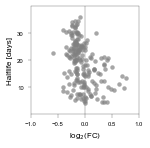

In [6]:
hl = pd.read_csv('./repos/protein_halflives.txt', sep='\t')
hl = hl.dropna()
df['hl'] = [hl.loc[hl.gene==x, 'halflife_days'].values[0] if x in hl.gene.tolist() else np.nan for x in df.gene]

fig = plt.figure(figsize=(1.5,1.5))
ax = fig.add_axes([0,0,1,1])
ax.axvline(0, lw=.25, zorder=-1)
ax.scatter('log2fc', 'hl', data=df.loc[df.mitocarta==1, :], c='.5', alpha=.7, s=20, lw=0)
ax.set_xlim([-1,1])
ax.set_ylim([0, 40])
ax.set_xticks(np.arange(-1, 1.2,.5))
ax.set_yticks(np.arange(10, 40,10))
ax.set_ylabel('Halflife [days]')
ax.set_xlabel('log$_{2}$(FC)')

fig.savefig('output/mitoproteomics_hl_chronic.pdf', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=.05)